In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

In [2]:
from pyoscomp.scenario.manager import ScenarioManager

In [3]:
import os
import shutil
import pandas as pd

--- Building Scenario 1: Uniform ---
Scenario 'Scenario_Uniform' created with UUID: 0694167d-fbe7-72e0-8000-a62356aa3867
Directory: demo_output/Scenario_Uniform


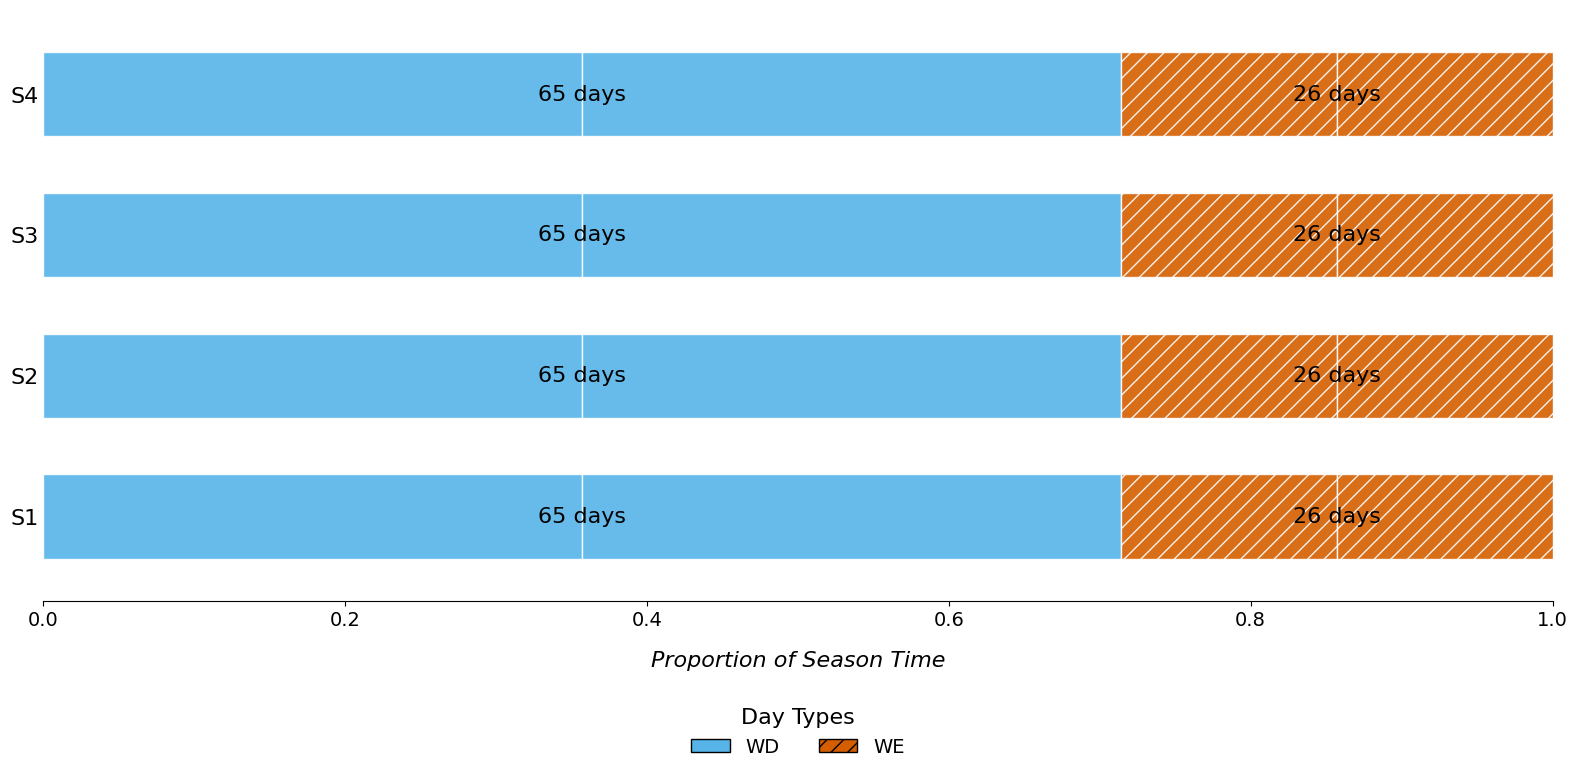


--- Building Scenario 2: High Complexity ---
Scenario 'Scenario_MaxComplexity' created with UUID: 0694167d-ff7b-7252-8000-d2a143d2a659
Directory: demo_output/Scenario_MaxComplexity
Scenario 2 generated at: demo_output/Scenario_MaxComplexity


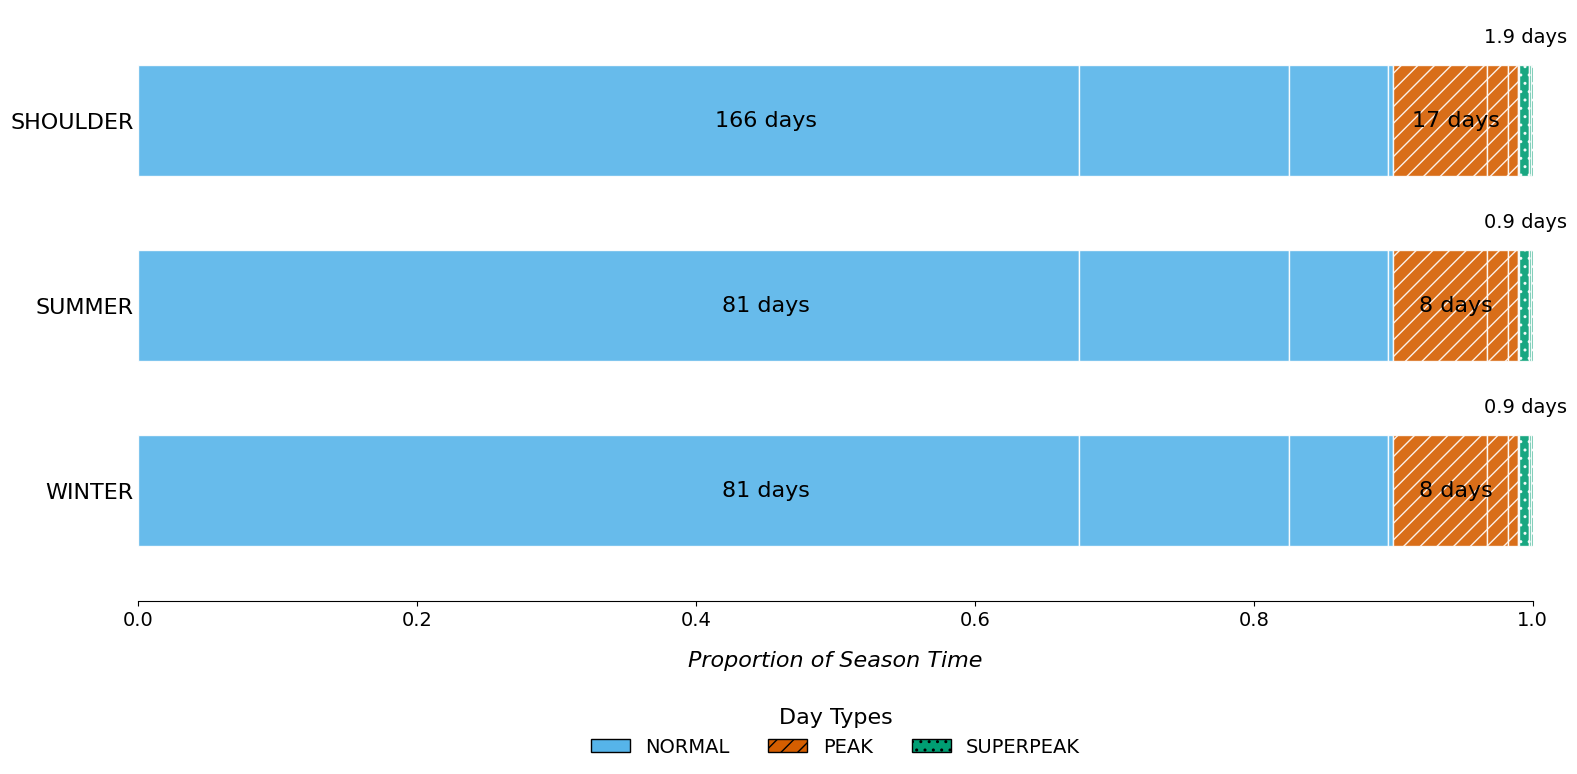

In [4]:
import os
import shutil
import yaml
import csv
from pyoscomp.scenario.manager import ScenarioManager

# --- Helper to clean up previous runs for this demo ---
WORK_DIR = "demo_output"
if os.path.exists(WORK_DIR):
    shutil.rmtree(WORK_DIR)
os.makedirs(WORK_DIR)

# Create a minimal config file for the demo
config_content = """
REGION:
  type: set
YEAR:
  type: set
SEASON:
  type: set
DAYTYPE:
  type: set
DAILYTIMEBRACKET:
  type: set
TIMESLICE:
  type: set
YearSplit:
  type: param
  columns: ["TIMESLICE", "YEAR", "VALUE"]
DaySplit:
  type: param
  columns: ["DAILYTIMEBRACKET", "YEAR", "VALUE"]
DaysInDayType:
  type: param
  columns: ["SEASON", "DAYTYPE", "YEAR", "VALUE"]
"""

config_path = os.path.join(WORK_DIR, "osemosys_config.yaml")
with open(config_path, "w") as f:
    f.write(config_content)

# ==========================================
# SCENARIO 1: Simple / Uniform
# ==========================================
print("--- Building Scenario 1: Uniform ---")
manager_1 = ScenarioManager(
    tag="Scenario_Uniform", 
    parent_dir=WORK_DIR,
    config_path=config_path,
    master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
)
s1 = manager_1.create_scenario()

s1.set_topology_structure(nodes=5)
s1.set_time_structure(
    years=(2020, 2030, 1),
    seasons={"S1": 1, "S2": 1, "S3": 1, "S4": 1}, 
    daytypes={"WD": 5, "WE": 2},                  
    brackets={"Day": 12, "Night": 12}             
)
s1.time.visualize_timeslices()

# ==========================================
# SCENARIO 2: Maximum Complexity (Cartesian)
# ==========================================
print("\n--- Building Scenario 2: High Complexity ---")
manager_2 = ScenarioManager(
    tag="Scenario_MaxComplexity", 
    parent_dir=WORK_DIR,
    config_path=config_path,
    master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
)
s2 = manager_2.create_scenario()
s2.set_topology_structure(nodes=["Grid_North", "Grid_South"])
s2.time.process_years((2025, 2030, 5))

# --- Complexity Configuration ---

# 1. SEASONS: Irregular lengths
seasons_conf = {
    "WINTER": 90,
    "SUMMER": 90,
    "SHOULDER": 185
}

# 2. DAY TYPES: 
# We include a "SuperPeak" day (e.g. 1-in-10 year cold snap).
# Even though it's rare, it gets its own DayType.
daytypes_conf = {
    "NORMAL": 0.90,    # Most days
    "PEAK": 0.09,      # High demand days
    "SUPERPEAK": 0.01  # Extreme anomaly (approx 3.6 days/year)
}

# 3. BRACKETS: 
# We include a "Critical Hour" (e.g., 6pm-7pm).
# Cartesian Note: This bracket will generate for ALL day types.
# - SUPERPEAK_CRITICAL_HOUR (The most dangerous hour of the decade)
# - NORMAL_CRITICAL_HOUR (Just 6pm on a Tuesday)
brackets_conf = {
    "BASE": 18,            # Bulk of the day
    "RAMP": 4,             # Morning/Evening ramps
    "PEAK_HOUR": 1.9,      # Standard peak window
    "CRITICAL_HOUR": 0.1   # Super sharp spike (6 minutes of terror? or 0.1 of day?)
                           # Let's say 0.1 fraction of day = 2.4 hours
}

# Process (No custom_conversions passed)
s2.time.process_time_structure(
    seasons=seasons_conf,
    daytypes=daytypes_conf,
    brackets=brackets_conf
)

print(f"Scenario 2 generated at: {s2.scenario_dir}")
s2.time.visualize_timeslices()


--- Listing All Scenarios ---
Found 2 scenarios:
  - Scenario_Uniform (0694167d-fbe7-72e0-8000-a62356aa3867)
  - Scenario_MaxComplexity (0694167d-ff7b-7252-8000-d2a143d2a659)

--- Loading Scenario by UUID ---
Loaded scenario 'Scenario_MaxComplexity' with UUID: 0694167d-ff7b-7252-8000-d2a143d2a659
Directory: demo_output/Scenario_MaxComplexity
Successfully loaded: Scenario_MaxComplexity


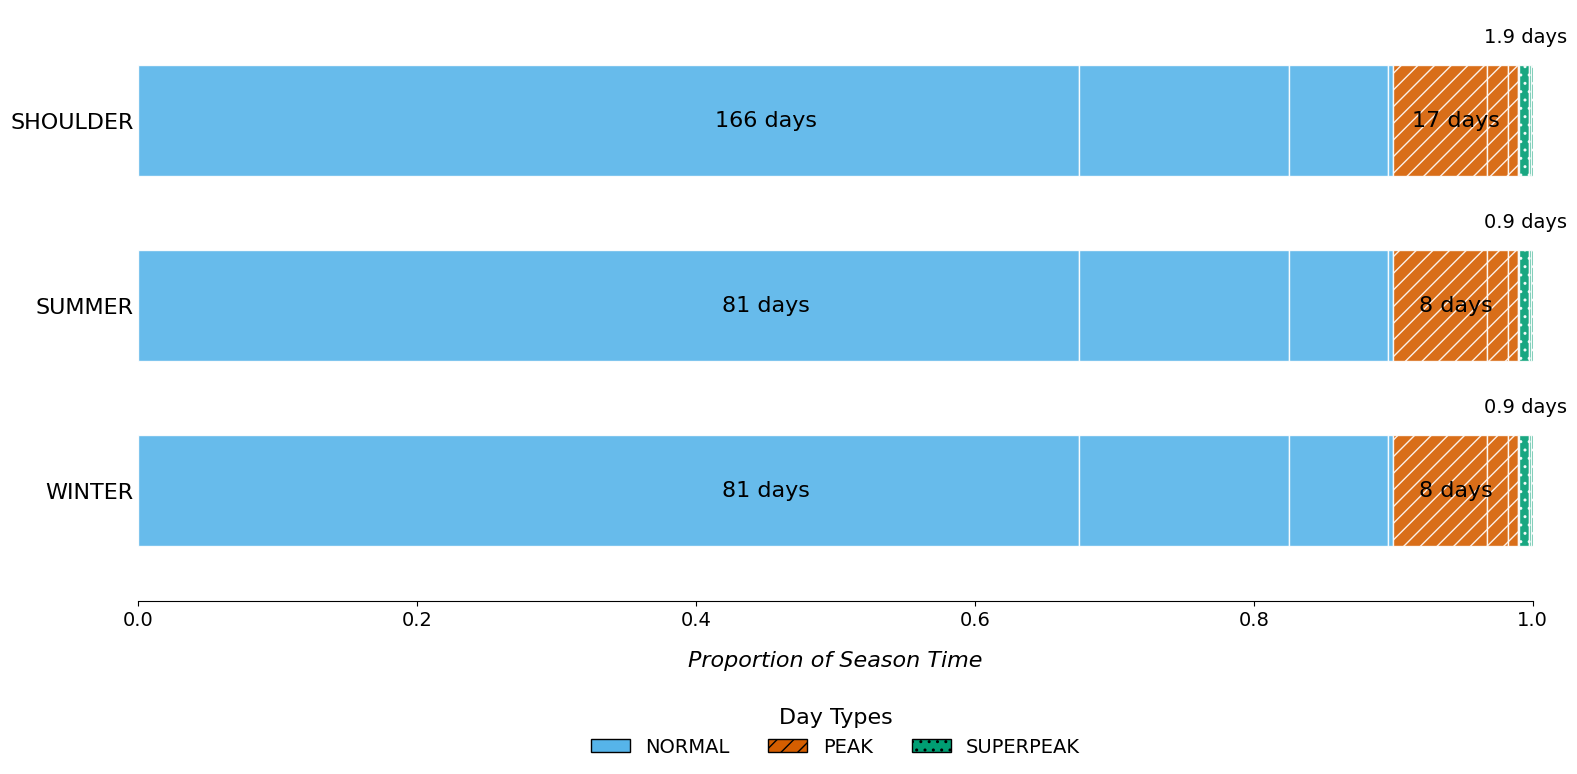

In [5]:
# ==========================================
# LIST AND LOAD DEMONSTRATION
# ==========================================
print("\n--- Listing All Scenarios ---")
# Create a manager without a tag to list scenarios
list_manager = ScenarioManager(
    parent_dir=WORK_DIR,
    config_path=config_path,
    master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
)

scenarios = list_manager.list_scenarios()
print(f"Found {len(scenarios)} scenarios:")
for scenario in scenarios:
    print(f"  - {scenario['tag']} ({scenario['uuid']})")

# ==========================================
# LOAD A SCENARIO BY UUID
# ==========================================
print("\n--- Loading Scenario by UUID ---")
if scenarios:
    sample_uuid = scenarios[-1]["uuid"]
    loaded_manager = ScenarioManager.from_uuid(
        uuid=sample_uuid,
        parent_dir=WORK_DIR,
        config_path=config_path,
        master_path=os.path.join(WORK_DIR, "scenarios_master_list.csv")
    )
    
    loaded_scenario = loaded_manager.load_scenario()
    print(f"Successfully loaded: {loaded_manager.tag}")
    loaded_scenario.time.visualize_timeslices()

    # You can now add more configuration to the loaded scenario
    # For example, add demand data (when that component is implemented)